In [1]:
# inspired from: A deep understanding of deep learning


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset


import sys



import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# %matplotlib widget
%matplotlib notebook
%matplotlib inline


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import gdown


!gdown https://drive.google.com/u/0/uc?id=1laTftYUbMfVTAfpcnd2QqQ3nkM5VgB9P&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1laTftYUbMfVTAfpcnd2QqQ3nkM5VgB9P
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:09<00:00, 155MB/s]


In [4]:
!unzip -qq -o /content/img_align_celeba.zip

!ls  /content/


img_align_celeba  img_align_celeba.zip	sample_data


In [5]:
!mkdir img
!mv /content/img_align_celeba /content/img

!ls  /content/

img  img_align_celeba.zip  sample_data


In [6]:

import torch
from torch.utils.data import Dataset
from torchvision import transforms


from torchvision.datasets import ImageFolder



# ## Setup
# # Number of gpus available
# ngpu = 1
# device = torch.device('cuda:0' if (
#     torch.cuda.is_available() and ngpu > 0) else 'cpu')

# ## Fetch data from Google Drive 
# # Root directory for the dataset
# data_root = 'data/celeba'
# # Path to folder with the dataset
# dataset_folder = f'{data_root}/img_align_celeba'
# # URL for the CelebA dataset
# url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# # Path to download the dataset to
# download_path = f'{data_root}/img_align_celeba.zip'

# # Create required directories 
# if not os.path.exists(data_root):
#   os.makedirs(data_root)
#   os.makedirs(dataset_folder)

# # Download the dataset from google drive
# gdown.download(url, download_path, quiet=False)

# # Unzip the downloaded file 
# with zipfile.ZipFile(download_path, 'r') as ziphandler:
#   ziphandler.extractall(dataset_folder)



## Load the dataset 
# Path to directory with all the images
# img_folder = f'{dataset_folder}/img_align_celeba'

# img_folder = f'/content/data/celeba/img_align_celeba'
# img_folder = f'/content/data/celeba/'



img_folder = f'/content/img'



In [7]:
transform = T.Compose([ T.ToTensor(),
                        T.Resize(64),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])


# dataset = torchvision.datasets.CelebA(root='./data', download=True, transform=transform)


dataset = ImageFolder(img_folder, transform)



batchsize   = 32
data_loader = DataLoader(dataset,batch_size=batchsize,shuffle=True,drop_last=True)

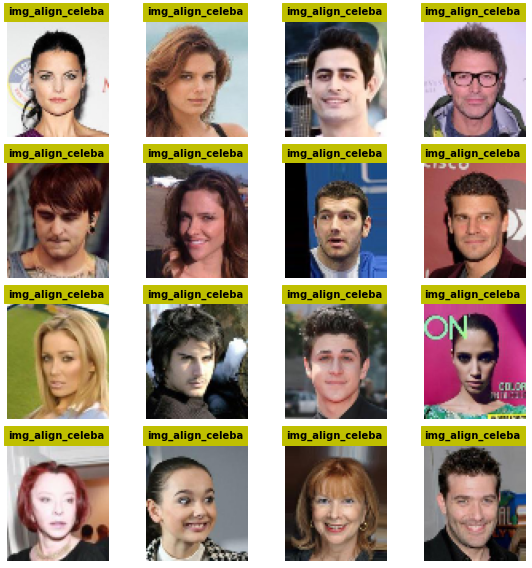

In [8]:
X,y = next(iter(data_loader))


fig,axs = plt.subplots(4,4,figsize=(8,8))

for (i,ax) in enumerate(axs.flatten()):

  # need to transpose it back to 32x32x3
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  
  label = dataset.classes[y[i]]

  ax.imshow(pic)
  ax.text(0,0,label,ha='left',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    


  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    
    return torch.sigmoid( self.conv5(x) ).view(-1,1)




dnet = discriminatorNet()
y = dnet(torch.randn(10,3,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 3, 64, 64])


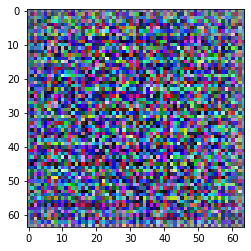

In [11]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)



  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x
    




gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)

pic = y[0,:,:,:].squeeze().detach().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
plt.imshow(pic);

In [12]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [13]:
len(data_loader)

6331

In [14]:
# num_epochs = 50
num_epochs = 20



c1 = 0
c2 = 0


losses  = []
disDecs = []

for epochi in range(num_epochs):

  print(f'start epochi -- {epochi}')


  for data,_ in data_loader:
    
    data = data.to(device)

    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)


    ### ---------------- Train the discriminator ---------------- ###

    pred_real   = dnet(data)                     # output of discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
    fake_images = gnet(fake_data)                           # output of generator
    pred_fake   = dnet(fake_images)                         # pass through discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()


    msg = f'\tTrain the discriminator -- {c1}'
    sys.stdout.write('\r' + msg)
    c1 += 1


    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = dnet(fake_images)

    g_loss = lossfun(pred_fake,real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    msg = f'\tTrain the generator -- {c2}'
    sys.stdout.write('\r' + msg)
    c2 += 1


    # collect losses and discriminator decisions
    losses.append([d_loss.item(),g_loss.item()])

    d1 = torch.mean((pred_real.cpu()>.5).float()).detach()
    d2 = torch.mean((pred_fake.cpu()>.5).float()).detach()
    disDecs.append([d1,d2])

  msg = f'Finished epoch {epochi+1}/{num_epochs}\n'
  sys.stdout.write('\r' + msg)


losses  = np.array(losses)
disDecs = np.array(disDecs)

start epochi -- 0
Finished epoch 1/20
start epochi -- 1
Finished epoch 2/20
start epochi -- 2
Finished epoch 3/20
start epochi -- 3
Finished epoch 4/20
start epochi -- 4
Finished epoch 5/20
start epochi -- 5
Finished epoch 6/20
start epochi -- 6
Finished epoch 7/20
start epochi -- 7
Finished epoch 8/20
start epochi -- 8
Finished epoch 9/20
start epochi -- 9
Finished epoch 10/20
start epochi -- 10
Finished epoch 11/20
start epochi -- 11
Finished epoch 12/20
start epochi -- 12
Finished epoch 13/20
start epochi -- 13
Finished epoch 14/20
start epochi -- 14
Finished epoch 15/20
start epochi -- 15
Finished epoch 16/20
start epochi -- 16
Finished epoch 17/20
start epochi -- 17
Finished epoch 18/20
start epochi -- 18
Finished epoch 19/20
start epochi -- 19
Finished epoch 20/20


In [15]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

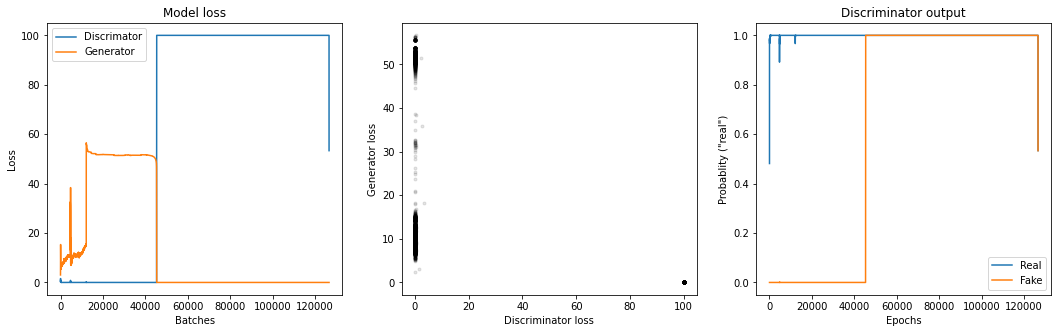

In [16]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([1500,2000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

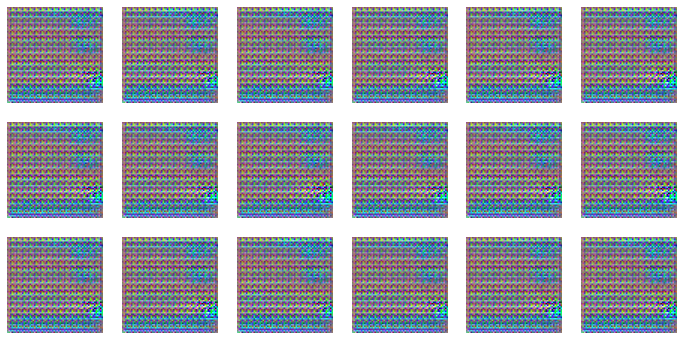

In [17]:
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic,cmap='gray')
  ax.axis('off')

plt.show()